## Setup

In [1]:
from neuron import h
from cell_inference.config import params, paths
import pandas as pd

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
# geo_standard = pd.read_csv(paths.GEO_STANDARD_AXON, index_col='id')
geo_standard = pd.read_csv(paths.GEO_STANDARD_OBLIQUE, index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

## Detailed Cell
First we generate the LFP heatmap and summary stats for the Detailed Cell Example. We have the detailed cell parameters specified and run via bmtk in another repository (detailed-single-cell). Therefore, we simply load the .h5 file containing the recorded LFP and generate summary stats from it to compare directly with the stylized model.

The detailed cell parameters are (Parameters marked with ^ are estimations, will be confirmed later):

| Model Number | $y$   | $d$  | $\theta$        | $h$                       | $\varphi$ | $r_s$ | $\ell_t$ | $r_t$ | $\ell_d$ |
|--------------|-------|------|-----------------|---------------------------|-----------|-------|----------|-------|----------|
| 496930324    | 350.0 | 80.0 | 0.0 | 0.0, $\frac{\pi}{4}$, 1.0 | 0.0       | 7.0^  | 500.0^   | 0.54^ | 200.0^   |

In [2]:
import os

DATA_PATH = 'cell_inference/resources/detailed'  # '/home/matt/data/InVivoLFPs/detailed_cell_simulation/without_basal_dendrite'
COORDS_PATH = os.path.join('cell_inference/resources', 'Electrode2D.h5')

# model_name = 'neuronal_model_496930324'
model_name = 'neuronal_model_491766131'
detailed_cells = [
    os.path.join(DATA_PATH, model_name+'_h0.0.h5'),
    os.path.join(DATA_PATH, model_name+'_h0.7071.h5'),
    os.path.join(DATA_PATH, model_name+'_h1.0.h5')
]
# detailed_cells = [
#     os.path.join(DATA_PATH, model_name+'_h1.0.h5')
# ]

## Stylized Cell
Next we rebuild and simulate the stylized cell model. The parameters are set to the same as the detailed model.

In [3]:
import numpy as np
import json

# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/'+model_name+'.json'
f = open(filepath)
biophys_param = json.load(f)
f.close()

# common parameters
biophys = [200, 50, 120] # Ra: basal, trunk, tuft
biophys_comm = {}#{'cm': 3.05}
# geo_param = [7., 500., .54, .3, .3, 200., .3] # (soma r,trunk l,trunk r,basal r,tuft r,dend l,axon r)
# geo_param = [7., 400., .6, .42, .2, 150., .2, .2, 100.] # (soma r,trunk l,trunk r,basal r,tuft r,dend l,axon r,oblique l)
geo_param = [7., 400., .6, .35, .1, 150., .15, .25, 100.] # (soma r,trunk l,trunk r,basal r,tuft r,dend l,axon r, oblique r, oblique l)
loc_param = [0., 350., 80., np.pi/4, 1.0, 0.]  # position (x,y,z,alpha,h,phi)
gmax = 0.02
stim_param = {'start': 2.}

# varying parameters
ncell = 1
# vary location parameters
nlocs = 3
loc_params = np.tile(loc_param,(nlocs,1)) 
loc_params[:,4] = [0.0, 0.7071, 1.0]
# loc_params[:,4] = [1.0]
loc_params = np.tile(loc_params,(ncell,1,1)) 

In [4]:
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes

sim = Simulation(geometry = geo_standard,
                 full_biophys = biophys_param,
                 electrodes = params.ELECTRODE_POSITION,
                 cell_type = CellTypes.ACTIVE_FULL,
                 biophys = biophys,
                 biophys_comm = biophys_comm,
                 loc_param = loc_params,
                 geo_param = geo_param,
                 spike_threshold = -30,
                 gmax = gmax,
                 stim_param = stim_param,
                 scale = 1.,
                 ncell = ncell)

In [5]:
%matplotlib notebook
from cell_inference.utils.plotting.plot_morphology import plot_morphology

# plot_morphology(sim, figsize=(6,6))

### Simulation results

In [6]:
sim.run_neuron_sim()
t = sim.t() 

#### Detailed cell

In [7]:
import h5py
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, get_y_window, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
data = []
bad_indices = []
y_pos = []
coordinates = []
start_list = []
end_list = []
tt = []

for i, sample in enumerate(detailed_cells):
    with h5py.File(sample, 'r') as f:
        lfp = f['data'][:].reshape((-1, 384))
        dt = f.attrs['dt']
    tt.append(np.arange(lfp.shape[0])*dt)

    start, end = get_spike_window(lfp, win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    start_list.append(start)
    end_list.append(end)
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(lfp[start:end,:], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    y_pos.append(y_i)
    coordinates.append(g_coords)
    data.append(g_lfp)  # time x channels

# ids = np.delete(ids, bad_indices, axis=0)
coordinates = np.stack(coordinates, axis=0)
# y_pos = np.stack(y_pos, axis=0)

#### Stylized cell

In [8]:
from scipy import signal

lfp = sim.get_lfp('all',multiple_position=True)  # (cells x locs x channels x time)
lfp = lfp.reshape((-1,)+lfp.shape[-2:]).transpose((0,2,1))  # -> (samples x channels x time) -> (samples x time x channels)

filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                               params.FILTER_CRITICAL_FREQUENCY,
                               params.BANDFILTER_TYPE,
                               fs=params.FILTER_SAMPLING_RATE)

start_idx = int(np.ceil(stim_param['start']/h.dt)) # ignore signal before
filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=1)[:,start_idx:,:]  # filter along time axis

pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
windowed_lfp = []
sty_data = []
sty_bad_indices = []
sty_y_pos = []
sty_coordinates = []
sty_start_list = []
sty_end_list = []

for i in range(filtered_lfp.shape[0]):
    #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    grid_y, _, _ = get_y_window(filtered_lfp[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0, grid_v=params.ELECTRODE_GRID)
    e_idx = (params.ELECTRODE_POSITION[:,1]>=grid_y[0]) & (params.ELECTRODE_POSITION[:,1]<=grid_y[-1])
    start, end = get_spike_window(filtered_lfp[i][:,e_idx], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    sty_start_list.append(start)
    sty_end_list.append(end)
    windowed_lfp.append(filtered_lfp[i,start:end,:])
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(windowed_lfp[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    sty_y_pos.append(y_i)
    sty_coordinates.append(g_coords)
    sty_data.append(g_lfp)  # time x channels

# ids = np.delete(ids, bad_indices, axis=0)
sty_coordinates = np.stack(sty_coordinates, axis=0)
print(sty_coordinates.shape)
# sty_y_pos = np.stack(sty_y_pos, axis=0)

(3, 196, 2)


#### LFP

Detailed cell


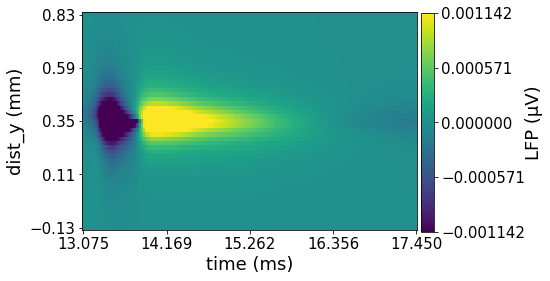

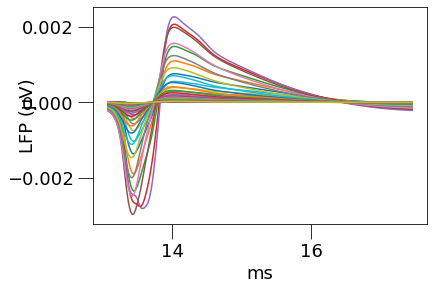

<Figure size 432x288 with 0 Axes>

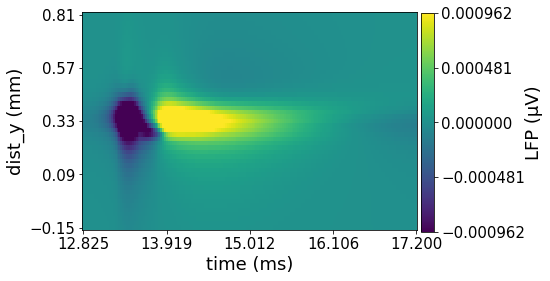

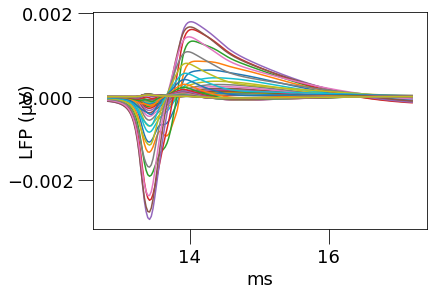

<Figure size 432x288 with 0 Axes>

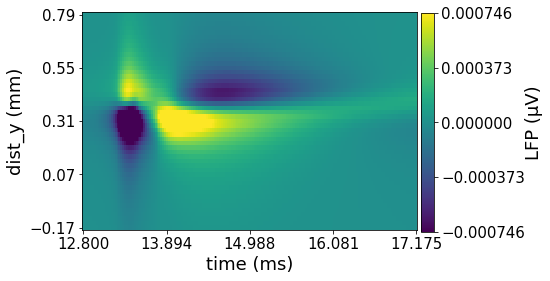

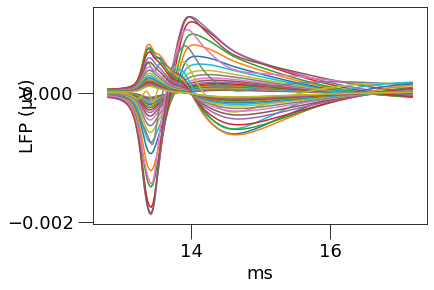

<Figure size 432x288 with 0 Axes>

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from importlib import reload
import cell_inference.utils.plotting.plot_results
reload(cell_inference.utils.plotting.plot_results)
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap
from cell_inference.utils.plotting.plot_results import plot_lfp_traces

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) &
         (g_coords[:,1]>=ylim[0]) &
         (g_coords[:,1]<=ylim[1]))

print('Detailed cell')

for j, d in enumerate(data):
    _ = plot_lfp_heatmap(t=tt[j][start_list[j]:end_list[j]],
                               elec_d=coordinates[j, e_idx, 1],
                               lfp=d[:,e_idx],
                               vlim='auto',
                               fontsize=18, labelpad=0, ticksize=15, nbins=5
                               )

    _ = plot_lfp_traces(tt[j][start_list[j]:end_list[j]], d[:,e_idx], fontsize=18)

    plt.tight_layout()

plt.show()

Stylized cell


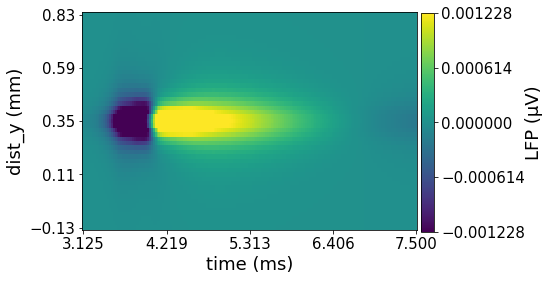

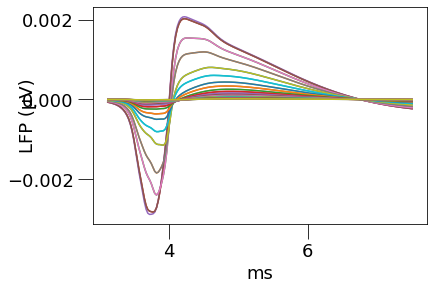

<Figure size 432x288 with 0 Axes>

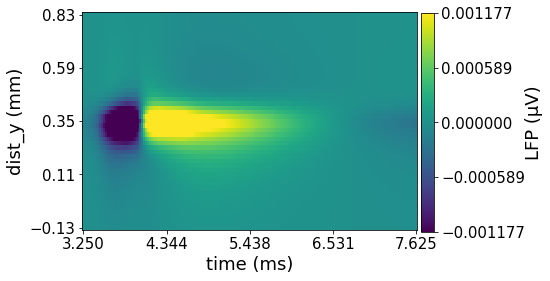

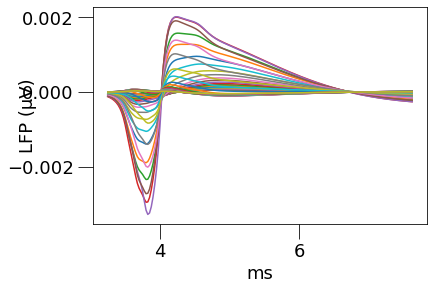

<Figure size 432x288 with 0 Axes>

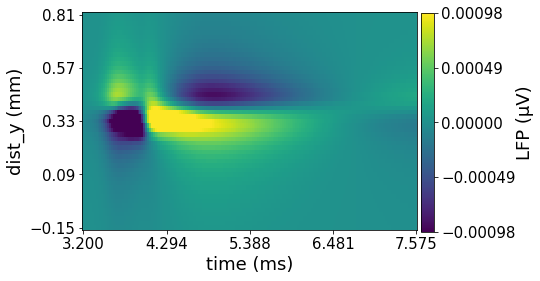

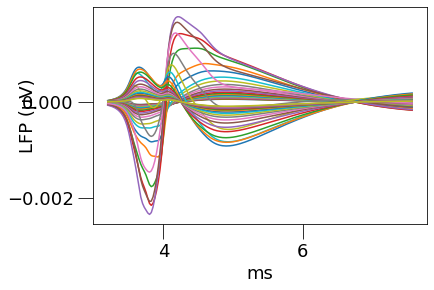

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline

print('Stylized cell')

for j, d in enumerate(sty_data):
    _ = plot_lfp_heatmap(t=t[sty_start_list[j]:sty_end_list[j]],
                               elec_d=sty_coordinates[j, e_idx, 1],
                               lfp=d[:,e_idx],
                               vlim='auto',
                               fontsize=18, labelpad=0, ticksize=15, nbins=5
                               )

    _ = plot_lfp_traces(t[sty_start_list[j]:sty_end_list[j]], d[:,e_idx], fontsize=18)

    plt.tight_layout()

plt.show()

#### Summary statistics

In [11]:
summ_stats = []
for g_lfp in data:
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = pd.DataFrame(data=np.array(summ_stats))
sty_summ_stats = []
for g_lfp in sty_data:
    sty_summ_stats.append(calculate_stats(g_lfp))
sty_summ_stats = pd.DataFrame(data=np.array(sty_summ_stats))

print('Detailed cell')
display(summ_stats)
print('Stylized cell')
display(sty_summ_stats)

Detailed cell


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000052,0.000068,2.0,24.0,0.000259,0.0,48.0,0.000002,28.979592,13.363047,...,0.002320,24.0,32.0,38.0,22.0,26.0,21.0,28.0,24.0,0.0
1,0.000042,0.000067,2.0,25.0,0.000253,0.0,37.0,-0.000010,8.806122,39.628803,...,0.001826,24.0,36.0,47.0,21.0,28.0,20.0,28.0,26.0,21.0
2,0.000012,0.000067,1.0,25.0,0.000195,1.0,31.0,-0.000110,-0.545918,42.121822,...,0.001229,24.0,35.0,47.0,19.0,27.0,20.0,28.0,30.0,22.0


Stylized cell


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000064,0.000087,2.0,24.0,0.000327,0.0,48.0,0.000003,43.081633,10.648056,...,0.002155,24.0,36.0,44.0,21.0,27.0,21.0,27.0,24.0,27.0
1,0.000051,0.000084,2.0,24.0,0.000298,1.0,35.0,-0.000018,7.280612,41.838829,...,0.002131,24.0,32.0,39.0,20.0,27.0,20.0,27.0,24.0,16.0
2,0.000011,0.000089,1.0,24.0,0.000240,3.0,30.0,-0.000165,2.673469,45.048902,...,0.001780,24.0,33.0,40.0,21.0,27.0,21.0,28.0,29.0,21.0
